# Clustering

## I. Imports & functions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from typing import Union, Tuple
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from dtaidistance import dtw_ndim
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score, adjusted_rand_score, adjusted_mutual_info_score

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

pd.options.display.max_columns = None
pd.options.display.max_colwidth = None

In [42]:
def plot_clustering(countries: pd.DataFrame, labels: np.array) -> None:
    """
    Plot cartogram presenting clustering results for given countries.

    Args:
        countries (pd.DataFrame): Pandas Dataframe containing at least one column, named 'countrycode', 
        with ISO-3166 alpha-3 codes of countries
        labels (np.array): cluster assignment generated by clustering model for given countries
    """
    fig = px.choropleth(countries, locations = 'countrycode', color = labels, projection='conic conformal')
    fig.update_geos(lataxis_range=[35, 75], lonaxis_range=[-15, 45]) # customized to show Europe only
    fig.show()
    
def plot_dendrogram(model: AgglomerativeClustering, labels : np.array = None) -> None:
    """
    Create linkage matrix and plot dendrogram for given Hierarchical Clustering model. 

    Args:
        model (AgglomerativeClustering): [description]
    """    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    # create linkage matrix from calculated counts
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    # plot the  dendrogram
    fig = plt.figure(figsize=(20,15))
    ax = fig.add_subplot(1,1,1)
    dendrogram(linkage_matrix, labels = labels)
    plt.xlabel('country codes', fontsize = 20)
    plt.ylabel('distance', fontsize = 20)
    ax.tick_params(axis = 'x', which = 'major', labelsize = 20)
    ax.tick_params(axis = 'y', which = 'major', labelsize = 20)
    

def kmeans_clustering(data: pd.DataFrame, n_clusters: int) -> TimeSeriesKMeans:
    """
    Perform KMeans clustering.

    Args:
        data (pd.DataFrame): preprocessed dataframe with economic indexes
        n_clusters (int): number of clusters to be formed

    Returns:
        TimeSeriesKMeans: fitted clustering model
    """
    # transform input data into adequate structure - 3D numpy array
    data_agg = data.drop('year', axis=1).groupby(['countrycode', 'country']).agg(list)
    n_countries = data_agg.shape[0] # number of points (countries)
    time_range =  len(data['year'].drop_duplicates()) # time range
    n_vars = data.shape[1] - 3 # number of economic indexes
    # filling the array
    data_agg_arr = np.empty(shape=(n_countries, n_vars, time_range))
    for i in range(data_agg.shape[0]):
        for j in range(data_agg.shape[1]):
            data_agg_arr[i][j] = np.array(data_agg.iloc[i,j])
    # creating and fitting a model
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric='dtw')
    model.fit(data_agg_arr)
    return model

def agglomerative_clustering(data: pd.DataFrame, n_clusters: int, linkage: str) -> AgglomerativeClustering:
    """
    Perform hierarchical clustering.

    Args:
        data (pd.DataFrame): preprocessed dataframe with economic indexes
        n_clusters (int): number of clusters to be formed
        linkage (str): type of linkage criterion; 'average', 'complete' or 'single'

    Returns:
        AgglomerativeClustering: fitted clustering model
    """
    # transform input data into adequate structure - 3D numpy array
    data_t = data.melt(id_vars=['countrycode','country','year'])
    data_t = data_t.groupby(['countrycode','country','year','variable'])['value'].aggregate('mean').unstack('year')
    data_t = data_t.reset_index().drop('variable', axis=1).groupby(['countrycode', 'country']).agg(list)
    n_countries = data_t.shape[0] # number of points (countries)
    time_range =  data_t.shape[1] # time range
    n_vars = data.shape[1] - 3 # number of economic indexes
    # filling the array
    data_t_arr = np.empty(shape=(n_countries, time_range, n_vars))
    for i in range(n_countries):
        for j in range(time_range):
            data_t_arr[i][j] = np.array(data_t.iloc[i,j])
    # calculating distances between points (countries)
    dtw_matrix = dtw_ndim.distance_matrix(data_t_arr, n_vars)
    # creating and fitting the model
    model = AgglomerativeClustering(
        n_clusters=n_clusters, affinity='precomputed', linkage=linkage, compute_distances=True)
    model.fit(dtw_matrix)
    return model

def dbscan_clustering(data: pd.DataFrame, eps: float, min_samples: int) -> DBSCAN:
    """
    Perform DBSCAN clustering.

    Args:
        data (pd.DataFrame): preprocessed dataframe with economic indexes
        eps (float): maximum distance between two points for them to be considered as neighbouring
        min_samples (int): number of samples in a neighborhood for a point to be considered as a core point

    Returns:
        DBSCAN: fitted clustering model
    """
    # transform input data into adequate structure - 3D numpy array
    data_t = data.melt(id_vars=['countrycode','country','year'])
    data_t = data_t.groupby(['countrycode','country','year','variable'])['value'].aggregate('mean').unstack('year')
    data_t = data_t.reset_index().drop('variable', axis=1).groupby(['countrycode', 'country']).agg(list)
    n_countries = data_t.shape[0] # number of points (countries)
    time_range =  data_t.shape[1] # time range
    n_vars = data.shape[1] - 3 # number of economic indexes
    # filling the array
    data_t_arr = np.empty(shape=(n_countries, time_range, n_vars))
    for i in range(n_countries):
        for j in range(time_range):
            data_t_arr[i][j] = np.array(data_t.iloc[i,j])
    # calculating distances between points (countries)
    dtw_matrix = dtw_ndim.distance_matrix(data_t_arr, n_vars)
    # creating and fitting the model
    model = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    model.fit(dtw_matrix)
    return model

def evaluate_clustering(data: pd.DataFrame, kmeans: np.array, agg: np.array, dbscan: np.array) -> pd.DataFrame:
    """
    Compare 3 used algoritms using following metrics: silhouette score (more to be defined).

    Args:
        data (pd.DataFrame): preprocessed dataframe with economic indexes
        kmeans (np.array): cluster assignment generated by KMeans clustering
        agg (np.array): cluster assignment generated by hierarchical clustering
        dbscan (np.array): cluster assignment generated by DBSCAN clustering

    Returns:
        pd.DataFrame: metrics values
    """
    # transform input data into adequate structure - 3D numpy array
    data_t = data.melt(id_vars=['countrycode','country','year'])
    data_t = data_t.groupby(['countrycode','country','year','variable'])['value'].aggregate('mean').unstack('year')
    data_t = data_t.reset_index().drop('variable', axis=1).groupby(['countrycode', 'country']).agg(list)
    n_countries = data_t.shape[0] # number of points (countries)
    time_range =  data_t.shape[1] # time range
    n_vars = data.shape[1] - 3 # number of economic indexes
    # filling the array
    data_t_arr = np.empty(shape=(n_countries, time_range, n_vars))
    for i in range(n_countries):
        for j in range(time_range):
            data_t_arr[i][j] = np.array(data_t.iloc[i,j])
    # calculating distances between points (countries)
    dtw_matrix = dtw_ndim.distance_matrix(data_t_arr, n_vars)
    # calculating metric values
    sil_score = [silhouette_score(dtw_matrix, kmeans, metric='precomputed'), 
            silhouette_score(dtw_matrix, agg, metric='precomputed'), 
            silhouette_score(dtw_matrix, dbscan, metric='precomputed')]
    results = pd.DataFrame([sil_score], columns=['Kmeans', 'Hierarchical', 'DBSCAN'], index=['Silhouette'])
    return results



## II. Data

In [5]:
data = pd.read_csv('data/data.csv')
data.head()

,countrycode,country,year,pop,rgdpna,delta,xr,csh_c,csh_i,csh_g,csh_x,csh_m,csh_r,rgdpna_per_cap,emp_percent,co2_emission,employment_agro,employment_industry,employment_services,export,import,inflation,net_migration,population_15_64,population_above_65,population_under_14,unemployment,urban_population,hdi
0,ALB,Albania,1990,0.020266,0.001841,0.151999,0.088576,0.475201,0.093659,0.317663,0.018863,0.954592,0.158237,0.021368,0.466870,0.040463,0.995473,0.023282,0.040798,0.035778,0.234066,0.026795,0.093730,0.045050,0.012636,0.995734,0.428295,0.008616,0.051255
1,ALB,Albania,1991,0.020158,0.001765,0.146769,0.122181,0.484793,0.087354,0.330491,0.018106,0.947753,0.157691,0.020529,0.450952,0.035597,0.993862,0.023786,0.042039,0.035841,0.258771,0.030538,0.097011,0.038567,0.017593,0.995729,0.429421,0.012412,0.042410
2,ALB,Albania,1992,0.020010,0.001737,0.140639,0.167289,0.487556,0.087580,0.339263,0.016650,0.942814,0.164122,0.020431,0.434157,0.030689,0.990899,0.024757,0.044296,0.036417,0.272822,0.032010,0.102411,0.031683,0.024157,0.994572,0.430850,0.017598,0.036869
3,ALB,Albania,1993,0.019828,0.001777,0.134270,0.221561,0.479223,0.095106,0.348672,0.014622,0.940917,0.179091,0.021354,0.419071,0.026408,0.986223,0.026156,0.047938,0.036917,0.269351,0.030130,0.110334,0.026117,0.032217,0.991197,0.432400,0.024219,0.037571
4,ALB,Albania,1994,0.019638,0.001881,0.128552,0.279895,0.459342,0.107618,0.369705,0.012502,0.941699,0.198760,0.023224,0.407361,0.023288,0.979889,0.027685,0.053085,0.036798,0.249430,0.025328,0.120462,0.024476,0.041217,0.984334,0.433774,0.032028,0.045982


In [6]:
# extracting list of pairs (country name + country code) for plots
countries = data[['countrycode','country']].drop_duplicates()

## III. Multivariate time series clustering

### III.I Kmeans

In [48]:
kmeans_ts = kmeans_clustering(data, 4)
plot_clustering(countries, kmeans_ts.labels_)

In [49]:
# tuning for optimal k
k_max = 10
inertias = []
for k in range(1, k_max+1):
    kmeans = kmeans_clustering(data, k)
    inertias.append(kmeans.inertia_)

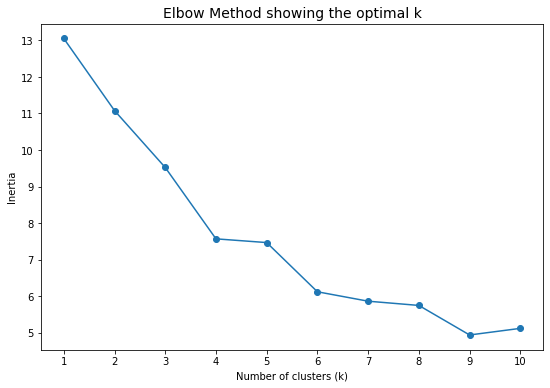

In [50]:
elbow = plt.plot(list(range(1, len(inertias) + 1)), inertias, '-o')
plt.title('Elbow Method showing the optimal k', size=14)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(list(range(1, len(inertias) + 1)));

### III.II Agglomerative clustering

In [7]:
agg_ts = agglomerative_clustering(data, 4, 'complete')
plot_clustering(countries, agg_ts.labels_)

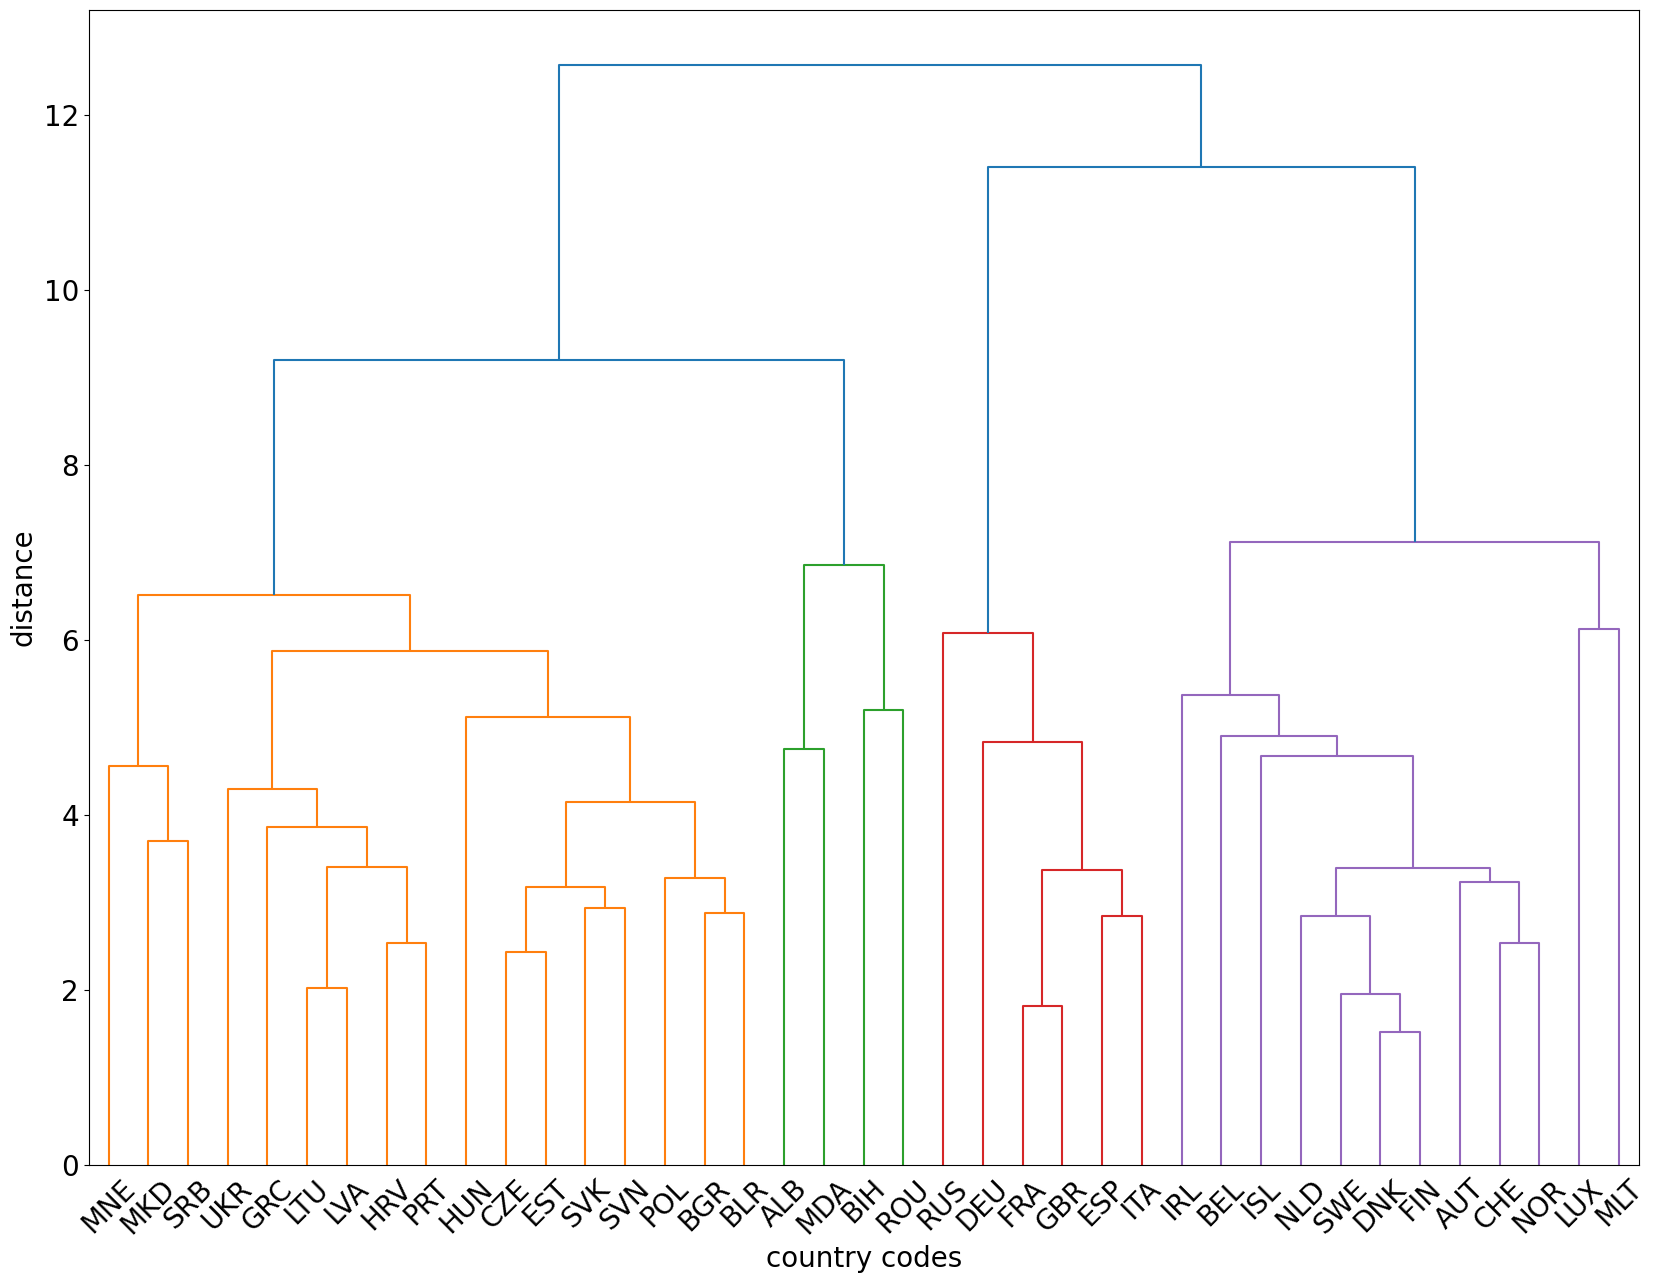

In [43]:
# visualisation of mergings
plot_dendrogram(agg_ts, np.array(countries.countrycode))

### III.III DBSCAN

In [53]:
# creating distance matrix for searching for optimal parameters
# transform input data into adequate structure - 3D numpy array
data_t = data.melt(id_vars=['countrycode','country','year'])
data_t = data_t.groupby(['countrycode','country','year','variable'])['value'].aggregate('mean').unstack('year')
data_t = data_t.reset_index().drop('variable', axis=1).groupby(['countrycode', 'country']).agg(list)
n_countries = data_t.shape[0] # number of points (countries)
time_range =  data_t.shape[1] # time range
n_vars = data.shape[1] - 3 # number of economic indexes
# filling the array
data_t_arr = np.empty(shape=(n_countries, time_range, n_vars))
for i in range(n_countries):
    for j in range(time_range):
        data_t_arr[i][j] = np.array(data_t.iloc[i,j])
# calculating distances between points (countries)
dtw_matrix = dtw_ndim.distance_matrix(data_t_arr, n_vars)

In [54]:
print('Min: ', np.min(dtw_matrix), ' Max: ', np.max(dtw_matrix)) # overview of distances

Min:  0.0  Max:  12.574017355208357


In [55]:
# tuning hyperparameters
min_grid = [x for x in range(2, 39, 1)] # min_samples parameter
eps_grid = np.arange(0.1, 12, 0.1) # eps parameter
best_params = {}
for m in min_grid:
    for e in eps_grid:
        dbscan = DBSCAN(eps = e, min_samples = m, metric='precomputed').fit(dtw_matrix)
        labels = dbscan.labels_
        if len(set(labels)) > 2: # at least 2 clusters + outliers 
            cal_score = silhouette_score(dtw_matrix, labels, metric='precomputed')

            if cal_score > 0:
                best_params[str(m) + " - " + str(e)] = cal_score
                
max_key = max(best_params, key = best_params.get)
print("parameter values are: ", max_key)
print("maximum silhouette score value is: ", best_params[max_key])

parameter values are:  2 - 3.2
maximum silhouette score value is:  0.11733396718909048


In [56]:
dbscan_ts = dbscan_clustering(data, 3.2, 2)
plot_clustering(countries, dbscan_ts.labels_)

## IV. Basic evaluation

In [57]:
evaluate_clustering(data, kmeans_ts.labels_, agg_ts.labels_, dbscan_ts.labels_)

,Kmeans,Hierarchical,DBSCAN
Silhouette,0.245828,0.238829,0.117334


## V. Flat data clustering (simple approach)

In [58]:
# flattened data transformed into a dataframe with column for each year x each variable
data_flat = data.melt(id_vars=['countrycode', 'country', 'year'])
data_flat['variable'] = data_flat['variable'] + '_' + data_flat['year'].astype(str)
data_flat.drop('year', axis=1, inplace=True)
data_flat = data_flat.groupby(['countrycode', 'country', 'variable'])['value'].aggregate('mean').unstack().reset_index()

### V.I KMeans

In [59]:
kmeans = KMeans(n_clusters=4)
y_kmeans = kmeans.fit_predict(data_flat.iloc[:, 2:])

In [60]:
plot_clustering(countries, y_kmeans)

In [61]:
# tuning for optimal k 
k_max = 10
inertias = []
for k in range(1, k_max+1):
    kmeans = KMeans(n_clusters=k)
    y_kmeans = kmeans.fit_predict(data_flat.iloc[:, 2:])
    inertias.append(kmeans.inertia_)

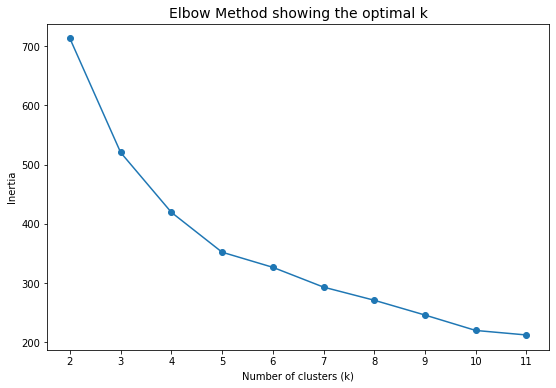

In [62]:
elbow = plt.plot(list(range(2, len(inertias)+2 )), inertias, '-o')
plt.title('Elbow Method showing the optimal k', size=14)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(list(range(2, len(inertias)+2 )));

### V.II AgglomerativeClustering

In [63]:
agglomerative = AgglomerativeClustering(linkage = 'complete', n_clusters = 4, compute_distances=True)
y_agg = agglomerative.fit_predict(data_flat.iloc[:, 2:])

In [64]:
plot_clustering(countries, y_agg)

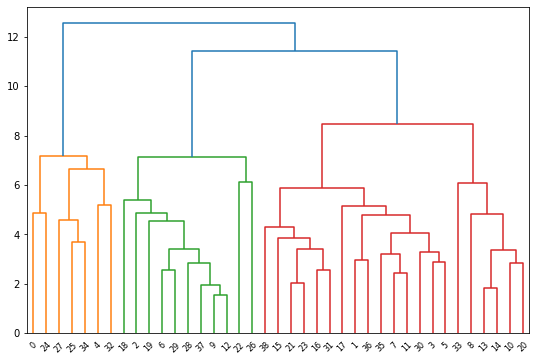

In [65]:
# visualisation of mergings
plot_dendrogram(agglomerative)

### IV.III OPTICS

In [66]:
# tuning hyperparameters
min_grid = [x for x in range(2, 39, 1)] # min_samples parameter
eps_grid = np.arange(0.1, 12, 0.1) # eps parameter
best_params = {}
for m in min_grid:
    for e in eps_grid:
        dbscan = DBSCAN(eps = e, min_samples = m).fit(data_flat.iloc[:, 2:])
        labels = dbscan.labels_
        if len(set(labels)) > 2: # at least 2 clusters + outliers 
            cal_score = silhouette_score(data_flat.iloc[:, 2:], labels)

            if cal_score > 0:
                best_params[str(m) + " - " + str(e)] = cal_score
                
max_key = max(best_params, key = best_params.get)
print("parameter values are: ", max_key)
print("maximum silhouette score value is: ", best_params[max_key])

parameter values are:  2 - 3.2
maximum silhouette score value is:  0.11733060032930819


In [67]:
dbscan = DBSCAN(eps=3.2, min_samples=2)
y_dbscan = dbscan.fit_predict(data_flat.iloc[:, 2:])

In [68]:
plot_clustering(countries, y_dbscan)